In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torch import nn
from torchvision import transforms

import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

data = torchvision.datasets.MNIST(root = './data', train = True, transform = transform, download = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 85430889.48it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 50620849.91it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30663566.25it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20484439.54it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



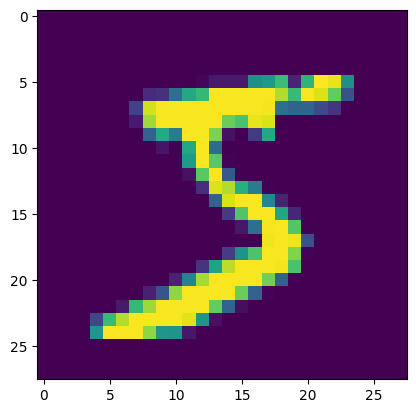

In [3]:
plt.imshow(data.data[0])

In [4]:
train_loader = DataLoader(data, batch_size = 256, shuffle = True)

In [5]:
print(data.data.shape)

torch.Size([60000, 28, 28])


In [7]:
class VAE(nn.Module):
  def __init__(self, d = 64):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784, d*8),
        nn.ReLU(),
        nn.Linear(d*8, d*4),
        nn.ReLU(),
        nn.Linear(d*4, d*2)
    )

    self.decoder = nn.Sequential(
        nn.Linear(d, d*4),
        nn.ReLU(),
        nn.Linear(d*4, d*8),
        nn.ReLU(),
        nn.Linear(d*8, 784),
        nn.Sigmoid()
    )

  def forward(self, x):
    mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, 64)
    mu = mu_logvar[:, 0, :]
    logvar = mu_logvar[:, 1, :]
    z = self.reparameterise(mu, logvar)
    return self.decoder(z), mu, logvar


  def reparameterise(self, mu, logvar):
    if self.training:
        std = logvar.mul(0.5).exp_()
        epsilon = std.data.new(std.size()).normal_()
        return epsilon.mul(std).add_(mu)
    else:
        return mu



In [8]:
def loss_function(x_hat, x, mu, logvar, beta=1):
  bce = nn.functional.binary_cross_entropy(
      x_hat, x.view(-1, 784), reduction='sum'
  )
  KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

  return bce + beta * KLD


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 5e-4)
model = model.to(device)

epochs = 20
reporting_steps = 60
epochs = 20
for epoch in range(0, epochs + 1):
  model.train()
  train_loss = 0.0
  for i, (x, _) in enumerate(train_loader):
    x = x.to(device)
    x_hat, mu, logvar = model(x)
    loss = loss_function(x_hat, x, mu, logvar)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % reporting_steps == reporting_steps - 1:
        print(f"Epoch {epoch} step {i} ave loss {train_loss/reporting_steps: .4f}")
        train_loss = 0.0

Epoch 0 step 59 ave loss  58208.6332
Epoch 0 step 119 ave loss  50829.3553
Epoch 0 step 179 ave loss  50350.1576
Epoch 1 step 59 ave loss  50252.8923
Epoch 1 step 119 ave loss  50151.7906
Epoch 1 step 179 ave loss  49891.4066
Epoch 2 step 59 ave loss  49150.0829
Epoch 2 step 119 ave loss  48815.4848
Epoch 2 step 179 ave loss  48910.6060
Epoch 3 step 59 ave loss  48501.0947
Epoch 3 step 119 ave loss  48649.7570
Epoch 3 step 179 ave loss  48576.6111
Epoch 4 step 59 ave loss  48515.6778
Epoch 4 step 119 ave loss  48638.9119
Epoch 4 step 179 ave loss  48885.8255
Epoch 5 step 59 ave loss  48331.9853
Epoch 5 step 119 ave loss  48220.2799
Epoch 5 step 179 ave loss  48264.2016
Epoch 6 step 59 ave loss  48151.8146
Epoch 6 step 119 ave loss  48479.8274
Epoch 6 step 179 ave loss  48295.1923
Epoch 7 step 59 ave loss  48508.0275
Epoch 7 step 119 ave loss  48841.7376
Epoch 7 step 179 ave loss  48346.5132
Epoch 8 step 59 ave loss  48101.3390
Epoch 8 step 119 ave loss  48345.3789
Epoch 8 step 179 ave 

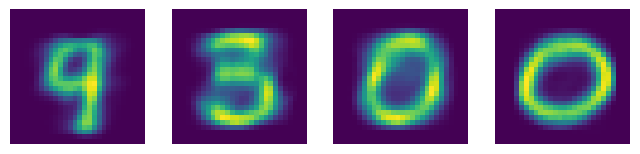

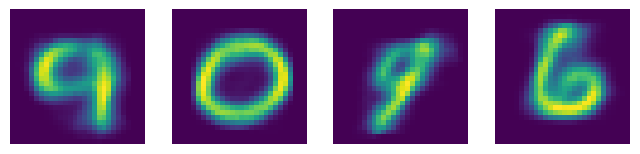

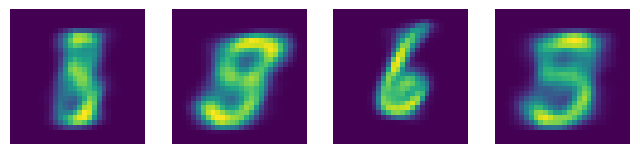

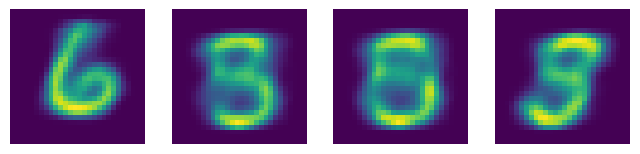

In [18]:
d = 64

def display_images(out, n=1):
    for N in range(n):
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(8, 4))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
N = 16
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(sample, N // 4)
